# plotting


In [1]:
# Enabling the `widget` backend.
# This requires the module ipympl (a.k.a jupyter-matplotlib )
# ipympl can be install from PyPi.
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%store -r log_text
from micropython_magic.memoryinfo import MemoryInfoList
mi_list = MemoryInfoList(show_free=False)
print(f"Loaded and parsed {len(mi_list.parse_log(log_text))} memory_info records from the log file")

Loaded and parsed 0 memory_info records from the log file


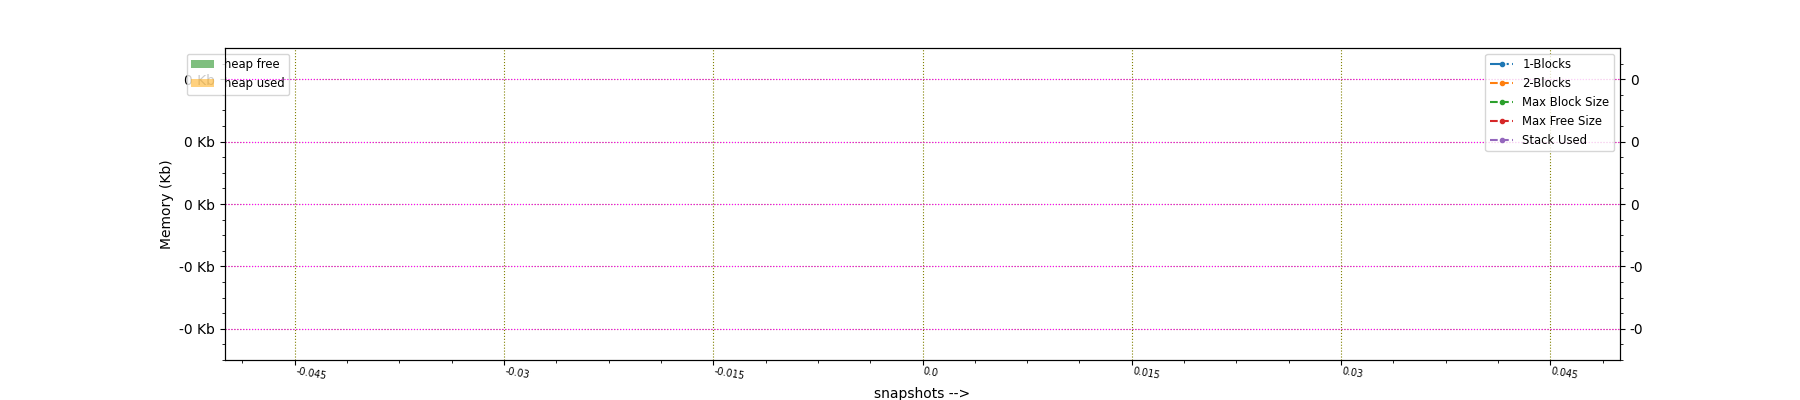

In [3]:
# clean up previous plot - save memory
# plt.close()

fig1 = mi_list.plot(
    free=True,
    # stack_total=True,
    one_blocks=True,
    two_blocks=True,
    max_block_size=True,
    max_free_size=True,
    stack_used=True,
    size=(18, 4),
)

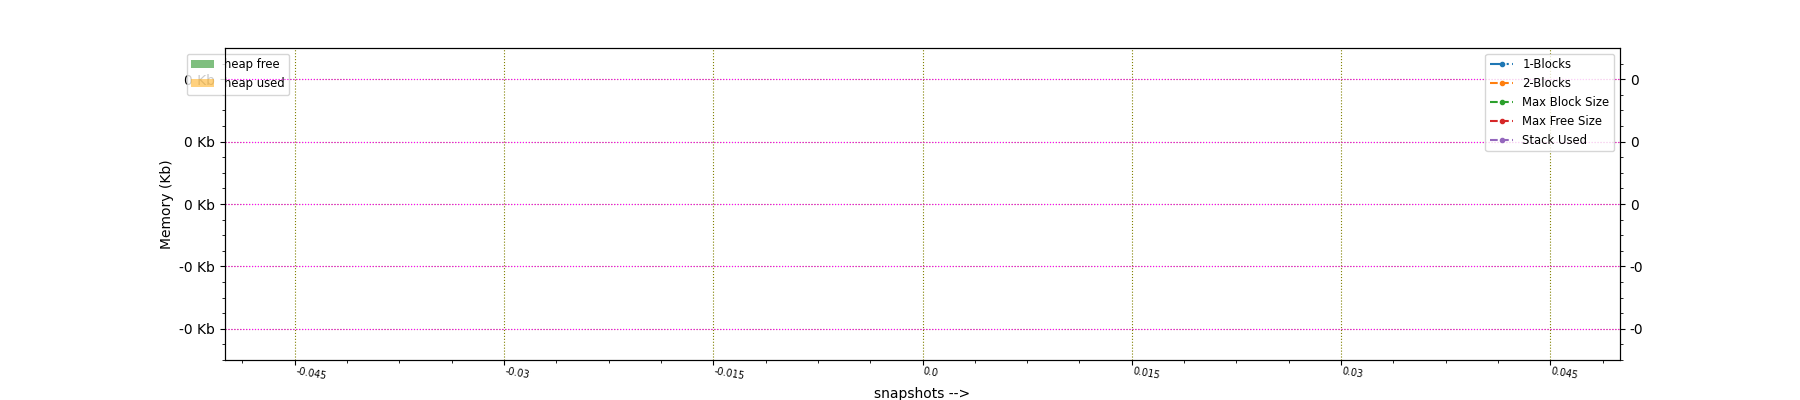

In [4]:
plt.show(fig1)

You can also call `display` on `fig.canvas` to display the interactive plot anywhere in the notebooke


Hover Over :

- https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-to-a-plot/47166787#47166787
- https://stackoverflow.com/questions/55891285/how-to-make-labels-appear-when-hovering-over-a-point-in-multiple-axis/55892690#55892690
-


In [5]:
# %%micropython
from micropython import mem_info
from time import gmtime, localtime, ticks_ms, time_ns


def timestamp():
    return time_ns() + ((ticks_ms() % 1_000_000) * 1_000)


def log_mem(id="", verbose=0):
    print(f"\n*** Memory info {id} ***")
    # add time to the log
    # print(f"time:{localtime()}")
    print(f"time:{timestamp()}")
    if verbose:
        mem_info(1)
    else:
        mem_info()
    print("***********************\n")

In [6]:
# %%micropython
import time
import random

log_mem("before")
for n in range(100):
    block = bytearray(500 + random.randint(0, 1000))
    log_mem(f"step {n}")
    time.sleep_ms(10)

log_mem("after")


*** Memory info before ***
time:1609463914756126000
stack: 756 out of 7936
GC: total: 210432, used: 56848, free: 153584
 No. of 1-blocks: 814, 2-blocks: 178, max blk sz: 265, max free sz: 8278
***********************


*** Memory info step 0 ***
time:1609463914764549000
stack: 756 out of 7936
GC: total: 210432, used: 58064, free: 152368
 No. of 1-blocks: 828, 2-blocks: 181, max blk sz: 265, max free sz: 8278
***********************


*** Memory info step 1 ***
time:1609463914783072000
stack: 756 out of 7936
GC: total: 210432, used: 59504, free: 150928
 No. of 1-blocks: 842, 2-blocks: 184, max blk sz: 265, max free sz: 8278
***********************


*** Memory info step 2 ***
time:1609463914811962000
stack: 756 out of 7936
GC: total: 210432, used: 57760, free: 152672
 No. of 1-blocks: 821, 2-blocks: 178, max blk sz: 265, max free sz: 8278
***********************


*** Memory info step 3 ***
time:1609463914830076000
stack: 756 out of 7936
GC: total: 210432, used: 58752, free: 151680
 No

In [7]:
output = _
# log_text = __
log_text = list(output)

In [8]:
from micropython_magic.memoryinfo import MemoryInfoList

mi_list = MemoryInfoList(show_free=False)
print(f"Loaded and parsed {len(mi_list.parse_log(log_text))} memory_info records from the log file")

Loaded and parsed 102 memory_info records from the log file


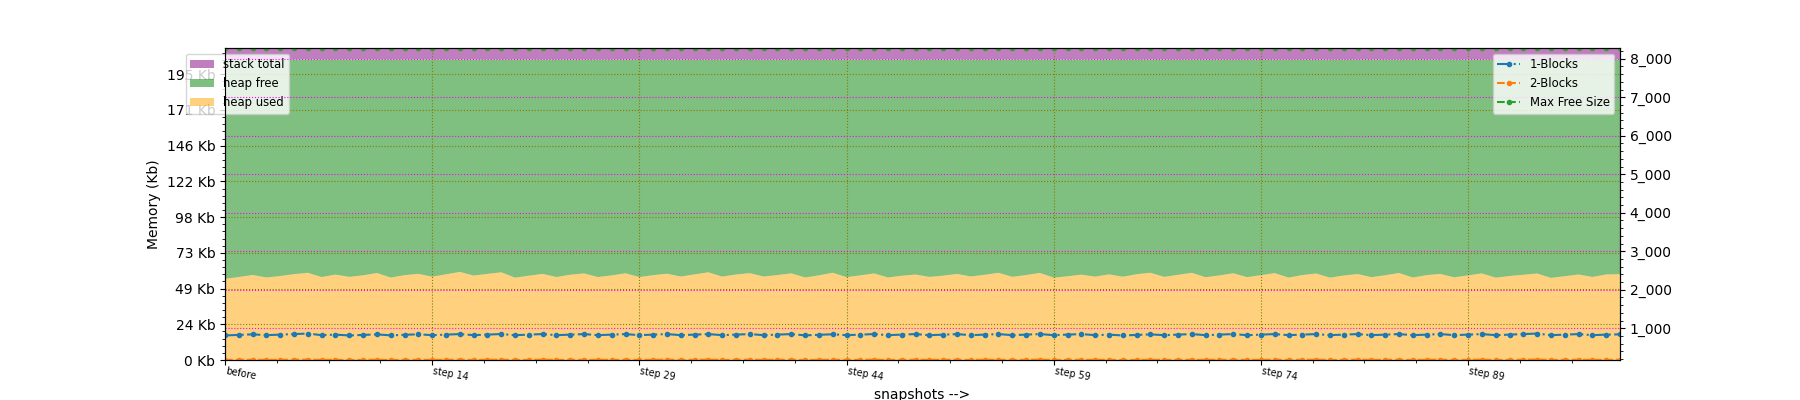

In [9]:
p2 = mi_list.plot(
    free=True,
    stack_total=True,
    one_blocks=True,
    two_blocks=True,
    # max_block_size=True,
    max_free_size=True,
    # stack_used=True,
    size=(18, 4),
    time_axis=False,
)

Plot with many text-labels on the x-axis
Labels are plotted sparly - and additional labels are added when zooming in
